# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy.

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement.

In [1]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm

In [2]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.

    Each step of the log-returns, there is a
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45

    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path

    Returns:

    Simuatled stock paths
    '''

    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))

    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))

    #Time increment between each step
    dt = t/n_steps

    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise

    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)


    #paths
    paths = S0*np.exp(log_returns)


    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)


    return paths


def bs_call(S0, K, sigma, t, r = 0):
    """
    Computes the Black-Scholes price of a European call option.

    Parameters:
        S0 (float): Current asset price
        K (float): Strike price
        sigma (float): Annualized volatility (standard deviation of log returns)
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)

    Returns:
        float: Call option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)

    call_price = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call_price

def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

def bs_MC_call(S0, K, sigma, r, t, mu = 0, n_sims = 2500, n_hedges = 50):

    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants


    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments


    Return:
    np.array of simulated values of Black-Scholes value of call option

    Warning:
    This function is not a true simulation. The Black-Scholes equation for Delta is not simulated.
    """
    #We will adjust this function later in the notebook to be a true Monte-Carlo simulation
    #Path simulation


    #Create random noise for n_sims number of paths with n_hedges steps in simulated stock movements

    noise = np.random.normal(0,1,(n_sims,n_hedges))


    #time interval between each step in simulated path
    dt = t/n_hedges

    increments = (mu+r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise #log_return increments

    log_returns = np.cumsum(increments, axis = 1)

    paths = S0*np.exp(log_returns)



    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)



    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0
    ### We are going to cheat at the current moment in our simulation
    ### We will use the Black-Scholes formula to find Delta,
    ### We'll simulate Delta later

    delta_start = bs_call_delta(S0,K,sigma,t,r)

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        deltas = bs_call_delta(stock_start, K, sigma, tte, r)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit


    return profits_hedged

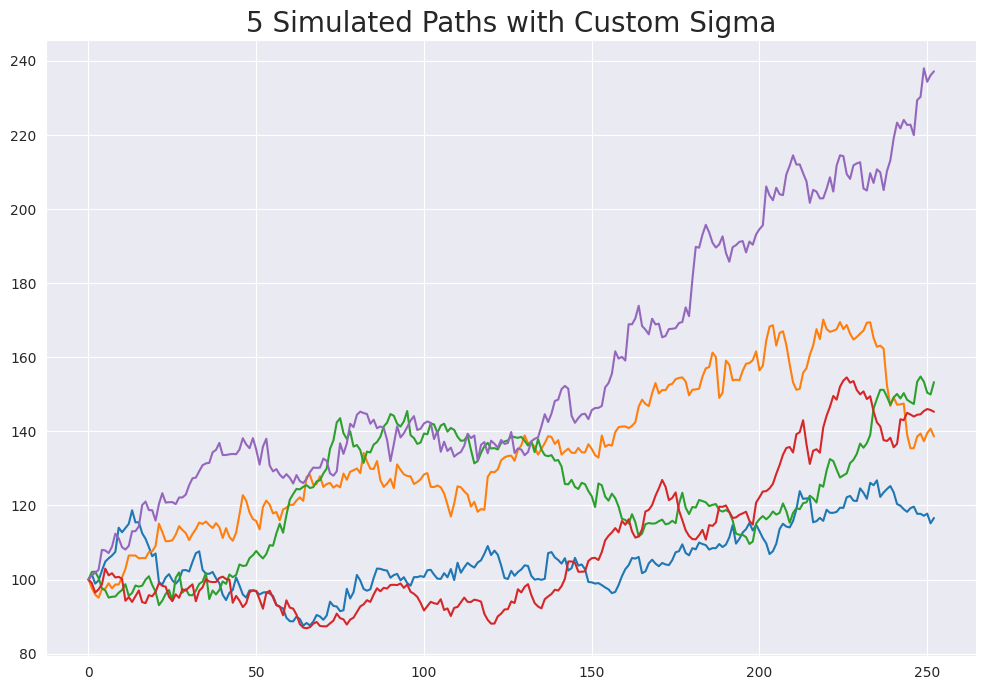

In [3]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)

plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

The first thing we do is: do the conventional hedging at periodic intervals with values of $\Delta$ obtained by calculating the volatility of the stock and setting it as constant.


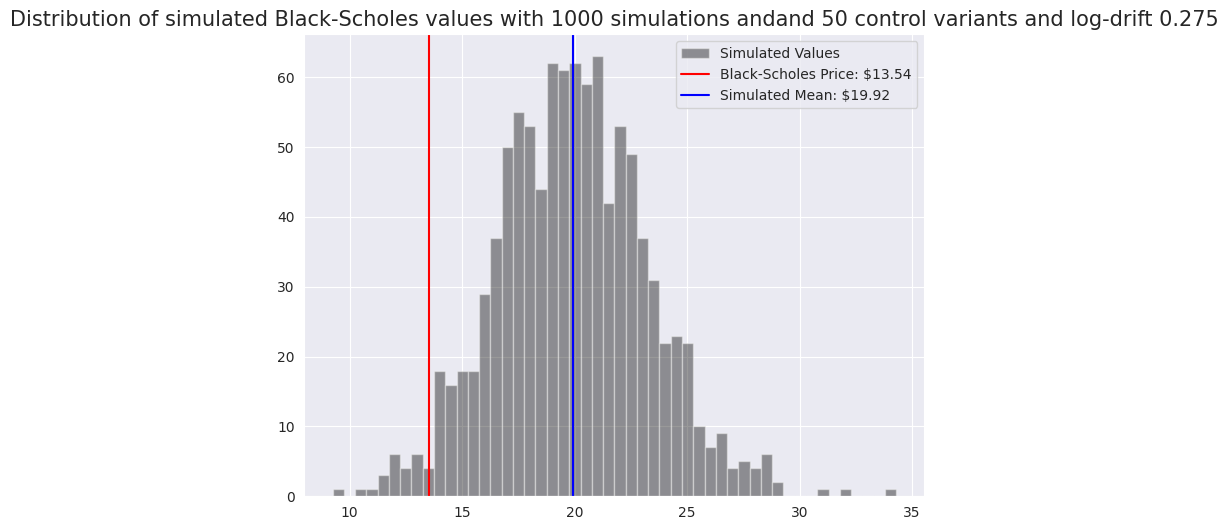

In [43]:
#We will calculate the Delta's for every path let's say n_hedge number of times. We will get an average value of $\sigma$ from MC data
S0 = 100
K = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 500
n_steps = 252

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)
annualized_volatility = 0
for path in simulated_paths:
  daily_returns = np.log(path/np.roll(path,1))
  daily_returns = daily_returns[~np.isnan(daily_returns)]
  annualized_volatility = np.std(daily_returns)*np.sqrt(252) + annualized_volatility

sigma = annualized_volatility/n_paths
#Now, we will proceed with this calculated \sigma
n_sims = 1000
n_hedges = 50

#simulated with the constant sigma
var_bs = np.dot(np.array([.2,.3,.45])**2, np.array([.5, .3, .2]))
sigma_bs = np.sqrt(var_bs)
bs_price = bs_call(S0,K,sigma_bs,t,r)

profits_hedged = bs_MC_call(S0, K, sigma, r, t, mu, n_sims, n_hedges)


plt.figure(figsize = (8,6))

plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')

plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')

plt.legend()

plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and\
and {n_hedges} control variants and log-drift {mu}',size = 15)

plt.show()

As we can see, the deviation from the Black Scholes value with the weighted $\sigma$ is very high when we do hedging with a average value of $\sigma$ estimated from the data.

$\Delta$ hedging when we know the prescription for the $\sigma$'s. We hedge at each time step with respect to the current value of $\sigma$.  



In [38]:
def MC_call_delta_custom(S0, K, t, r,mu, n_paths,n_steps):
    """Description:
    Monte-Carlo Simulation of Black-Scholes Call Delta

    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (array): array of volatilities
    sigma_probs (array): probabilities of sigmas
    t (float): time to expiration
    r (float): risk-free interest rate

    Return
    Array of hedged profits with hedging at every time step.

    """
    bump = .01*S0
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    dt = t/n_steps
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    log_returns = np.cumsum(increments, axis = 1)


    paths = S0*np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis = 1)
    paths_first_steps = paths[:,0]
    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)
    stock_profits = []
    stock_profits.append(first_stock_profits)

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)

    delta_start = bs_call_delta(S0,K,sigma,t,r)

    for i in range(1,n_steps+1):
      stock_start = paths[:,i-1]
      stock_end = paths[:,i]
      tte = t-i*dt
      deltas = bs_call_delta(stock_start, K, sigma[:,i-1], tte, r)
      stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
      stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit

    return profits_hedged

/tmp/ipython-input-2-4153577948.py:86: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))


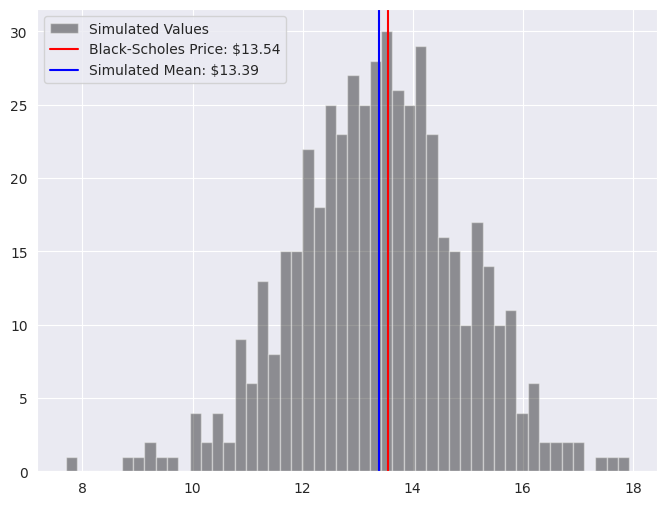

In [41]:
S0 = 100
K = 100
t = 1
r = 0.039
mu = 0.275
n_sims = 500
n_steps = 252
profits_hedged = MC_call_delta_custom(S0, K, t, r,mu, n_sims, n_steps)

var_bs = np.dot(np.array([.2,.3,.45])**2, np.array([.5, .3, .2]))
sigma_bs = np.sqrt(var_bs)
bs_price = bs_call(S0,K,sigma_bs,t,r)

plt.figure(figsize = (8,6))

plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')

plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')

plt.legend()

Now, once we hedge at every time step keeping in mind how $\sigma$ changes, the performance is much better as compared to before. Let us move on to Sigma/Vega hedging

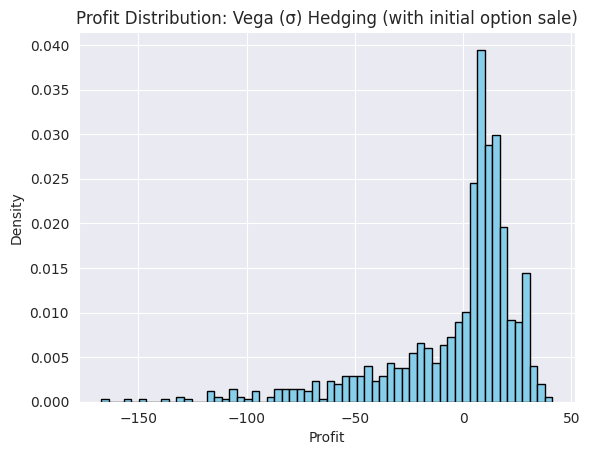

In [46]:
def bs_vega(S, K, T, r, sigma):
    if T <= 0: return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def bs_call_price(S, K, T, r, sigma):
    if T <= 0: return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

S0 = 100
K1 = 100   # Main option strike
K2 = 105   # Hedge option strike
r = 0.01
T = 1.0
n_steps = 50
dt = T / n_steps
n_paths = 1000
vol_choices = [0.2, 0.3, 0.45]
vol_probs = [0.5, 0.3, 0.2]


sigma_paths = np.random.choice(vol_choices, p=vol_probs, size=(n_paths, n_steps))


S_paths = np.zeros((n_paths, n_steps + 1))
S_paths[:, 0] = S0
for t in range(n_steps):
    sigma = sigma_paths[:, t]
    Z = np.random.normal(0, 1, size=n_paths)
    S_paths[:, t+1] = S_paths[:, t] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)


profits = []

for i in range(n_paths):
    sigma_path = sigma_paths[i]
    S_path = S_paths[i]

    hedge_position = 0
    cash = 0

    # At t=0: sell 1 unit of main option → receive premium
    initial_sigma = sigma_path[0]
    initial_price_main = bs_call_price(S0, K1, T, r, initial_sigma)
    cash += initial_price_main  # received from selling the option

    for t in range(n_steps):
        tau = T - t * dt
        if tau <= 0: break

        sig = sigma_path[t]
        St = S_path[t]

        vega1 = bs_vega(St, K1, tau, r, sig)
        vega2 = bs_vega(St, K2, tau, r, sig)
        hedge_price = bs_call_price(St, K2, tau, r, sig)

        # Compute hedge weight
        new_hedge_position = -vega1 / vega2 if vega2 != 0 else 0

        # Rebalancing cost
        d_hedge = new_hedge_position - hedge_position
        cash -= d_hedge * hedge_price  # buy/sell hedge options
        hedge_position = new_hedge_position

        # Interest accrues
        cash *= np.exp(r * dt)

    # At maturity
    ST = S_path[-1]
    payoff_main = max(ST - K1, 0)
    payoff_hedge = hedge_position * max(ST - K2, 0)

    final_value = cash + payoff_hedge
    profit = final_value - payoff_main  # since we owe 1 call payoff
    profits.append(profit)

# === Plot the profit distribution ===
plt.hist(profits, bins=60, density=True, color='skyblue', edgecolor='black')
plt.title("Profit Distribution: Vega (σ) Hedging (with initial option sale)")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.grid(True)
plt.show()



Now, we combine Delta and Sigma hedging

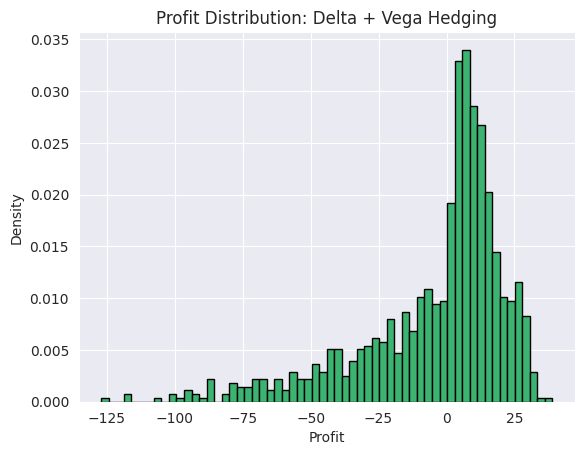

In [47]:

def bs_delta(S, K, T, r, sigma):
    if T <= 0: return 0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1)

S0 = 100
K1 = 100  # Strike of main option
K2 = 105  # Strike of hedge option
r = 0.01
T = 1.0
n_steps = 50
dt = T / n_steps
n_paths = 1000

# Volatility scenarios
vol_choices = [0.2, 0.3, 0.45]
vol_probs = [0.5, 0.3, 0.2]

sigma_paths = np.random.choice(vol_choices, p=vol_probs, size=(n_paths, n_steps))


S_paths = np.zeros((n_paths, n_steps + 1))
S_paths[:, 0] = S0
for t in range(n_steps):
    sigma = sigma_paths[:, t]
    Z = np.random.normal(0, 1, size=n_paths)
    S_paths[:, t+1] = S_paths[:, t] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

profits = []

for i in range(n_paths):
    S_path = S_paths[i]
    sigma_path = sigma_paths[i]

    stock_position = 0
    hedge_position = 0
    cash = 0

    # Initial: sell one main option, receive premium
    initial_sigma = sigma_path[0]
    option_price_main = bs_call_price(S0, K1, T, r, initial_sigma)
    cash += option_price_main

    for t in range(n_steps):
        tau = T - t * dt
        if tau <= 0:
            break

        St = S_path[t]
        sigma_t = sigma_path[t]

        # Compute Greeks
        delta1 = bs_delta(St, K1, tau, r, sigma_t)
        delta2 = bs_delta(St, K2, tau, r, sigma_t)
        vega1 = bs_vega(St, K1, tau, r, sigma_t)
        vega2 = bs_vega(St, K2, tau, r, sigma_t)

        hedge_price = bs_call_price(St, K2, tau, r, sigma_t)


        new_hedge_position = -vega1 / vega2 if vega2 != 0 else 0
        new_stock_position = delta1 + new_hedge_position * delta2


        d_stock = new_stock_position - stock_position
        d_hedge = new_hedge_position - hedge_position

        cash -= d_stock * St + d_hedge * hedge_price

        stock_position = new_stock_position
        hedge_position = new_hedge_position

        cash *= np.exp(r * dt)

    ST = S_path[-1]
    payoff_main = max(ST - K1, 0)
    payoff_hedge = hedge_position * max(ST - K2, 0)
    stock_value = stock_position * ST

    portfolio_value = stock_value + payoff_hedge + cash
    profit = portfolio_value - payoff_main  # we owe the call payoff
    profits.append(profit)

plt.hist(profits, bins=60, density=True, color='mediumseagreen', edgecolor='black')
plt.title("Profit Distribution: Delta + Vega Hedging")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.grid(True)
plt.show()



Finally, we look at Sigma hedging with the Heston model for volatility

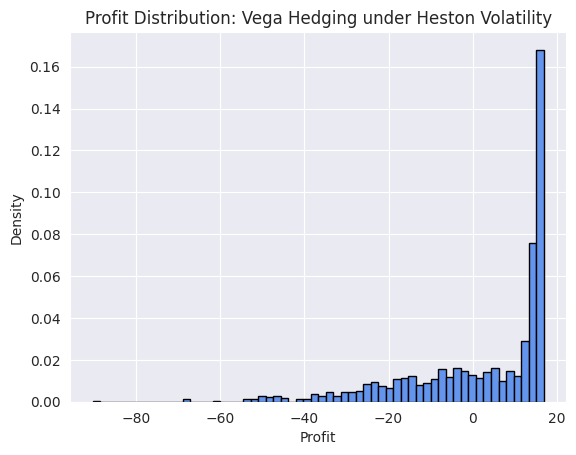

In [49]:


#Heston parameters
S0 = 100
v0 = 0.04           # initial variance
kappa = 2.0         # mean reversion rate
theta = 0.04        # long-term variance
xi = 0.3            # vol of vol
rho = -0.7          # correlation
r = 0.01
T = 1.0
n_steps = 50
dt = T / n_steps
n_paths = 1000

K1 = 100  # primary
K2 = 105  # hedge


S_paths = np.zeros((n_paths, n_steps + 1))
v_paths = np.zeros((n_paths, n_steps + 1))
S_paths[:, 0] = S0
v_paths[:, 0] = v0

for t in range(n_steps):
    Z1 = np.random.normal(size=n_paths)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_paths)

    v_prev = v_paths[:, t]
    v_prev = np.maximum(v_prev, 1e-8)  # ensure positivity
    sqrt_v = np.sqrt(v_prev)

    v_next = v_prev + kappa * (theta - v_prev) * dt + xi * sqrt_v * np.sqrt(dt) * Z2
    v_paths[:, t + 1] = np.maximum(v_next, 1e-8)

    S_paths[:, t + 1] = S_paths[:, t] * np.exp((r - 0.5 * v_prev) * dt + sqrt_v * np.sqrt(dt) * Z1)


profits = []

for i in range(n_paths):
    S_path = S_paths[i]
    v_path = v_paths[i]
    cash = 0
    hedge_position = 0

    sigma0 = np.sqrt(v_path[0])
    cash += bs_call_price(S0, K1, T, r, sigma0)  # sold main option

    for t in range(n_steps):
        tau = T - t * dt
        if tau <= 0: break

        St = S_path[t]
        sigma_t = np.sqrt(max(v_path[t], 1e-8))

        vega1 = bs_vega(St, K1, tau, r, sigma_t)
        vega2 = max(bs_vega(St, K2, tau, r, sigma_t), 1e-8)  # avoid zero

        hedge_price = bs_call_price(St, K2, tau, r, sigma_t)

        new_hedge_position = np.clip(-vega1 / vega2, -100, 100)
        d_hedge = new_hedge_position - hedge_position
        cash -= d_hedge * hedge_price
        hedge_position = new_hedge_position

        cash *= np.exp(r * dt)

    ST = S_path[-1]
    payoff_main = max(ST - K1, 0)
    payoff_hedge = hedge_position * max(ST - K2, 0)
    final_value = cash + payoff_hedge
    profit = final_value - payoff_main
    profits.append(profit)

plt.hist(profits, bins=60, density=True, color='cornflowerblue', edgecolor='black')
plt.title("Profit Distribution: Vega Hedging under Heston Volatility")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.grid(True)
plt.show()


Sigma hedging with GARCH volatility

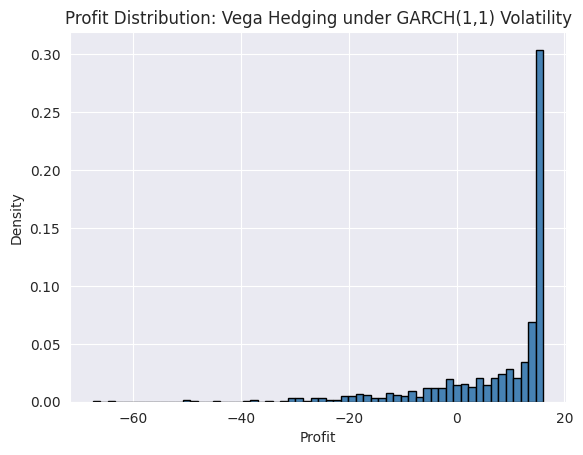

In [50]:
#GARCH(1,1)
omega = 0.000002
alpha = 0.05
beta = 0.94


S0 = 100
r = 0.01
mu = 0.05
T = 1.0
n_steps = 252  # Daily steps for realism
dt = T / n_steps
n_paths = 1000

K1 = 100  # main option strike
K2 = 105  # hedge option strike

profits = []

for i in range(n_paths):
    S_path = np.zeros(n_steps + 1)
    sigma_path = np.zeros(n_steps + 1)
    eps_path = np.zeros(n_steps + 1)

    S_path[0] = S0
    sigma_path[0] = 0.2  # starting vol
    eps_path[0] = 0

    for t in range(1, n_steps + 1):
        sigma_sq = omega + alpha * eps_path[t - 1]**2 + beta * sigma_path[t - 1]**2
        sigma = np.sqrt(max(sigma_sq, 1e-8))
        Z = np.random.normal()
        eps = sigma * Z

        S_path[t] = S_path[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        sigma_path[t] = sigma
        eps_path[t] = eps


    cash = 0
    hedge_position = 0

    sigma0 = sigma_path[0]
    cash += bs_call_price(S0, K1, T, r, sigma0)

    for t in range(n_steps):
        tau = T - t * dt
        if tau <= 0:
            break

        St = S_path[t]
        sigma_t = sigma_path[t]

        vega1 = bs_vega(St, K1, tau, r, sigma_t)
        vega2 = max(bs_vega(St, K2, tau, r, sigma_t), 1e-8)
        hedge_price = bs_call_price(St, K2, tau, r, sigma_t)

        new_hedge_position = np.clip(-vega1 / vega2, -100, 100)
        d_hedge = new_hedge_position - hedge_position

        cash -= d_hedge * hedge_price
        hedge_position = new_hedge_position
        cash *= np.exp(r * dt)

    ST = S_path[-1]
    payoff_main = max(ST - K1, 0)
    payoff_hedge = hedge_position * max(ST - K2, 0)
    final_value = cash + payoff_hedge
    profit = final_value - payoff_main
    profits.append(profit)


plt.hist(profits, bins=60, density=True, color='steelblue', edgecolor='black')
plt.title("Profit Distribution: Vega Hedging under GARCH(1,1) Volatility")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.grid(True)
plt.show()
